In [4]:
import pandas as pd 
import numpy as np
import joblib
import time
import shap
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## SHAP

In [2]:
test = pd.read_csv('./DS/test_SFS.csv')
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.DataFrame(y_test)
labels = label_encoder.classes_

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original -> Encoded):")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label} -> {encoded_label}")

Label Mapping (Original -> Encoded):
NORMAL -> 0
c_ci_na_1 -> 1
c_ci_na_1_DoS -> 2
c_rd_na_1 -> 3
c_rd_na_1_DoS -> 4
c_rp_na_1 -> 5
c_rp_na_1_DoS -> 6
c_sc_na_1 -> 7
c_sc_na_1_DoS -> 8
c_se_na_1 -> 9
c_se_na_1_DoS -> 10
m_sp_na_1_DoS -> 11


In [3]:
X_train = pd.read_csv('./DS/CFM_DS_X_train.csv')
y_train = pd.read_csv('./DS/CFM_DS_y_train.csv')
X_test = pd.read_csv('./DS/X_test_SFS.csv')
y_test = pd.read_csv('./DS/y_test_SFS.csv')

In [4]:
print("RandomForestClassifier Starting")
rf_model = RandomForestClassifier()
rf_model = joblib.load('./models/rf.pkl')
rf_prediction = rf_model.predict(X_test)
print("RandomForestClassifier Finished")

rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)
print("RandomForest report:")
print("RandomForest Accuracy:", rf_acc)

RandomForestClassifier Starting
RandomForestClassifier Finished
RandomForest report:
RandomForest Accuracy: 0.8678500986193294


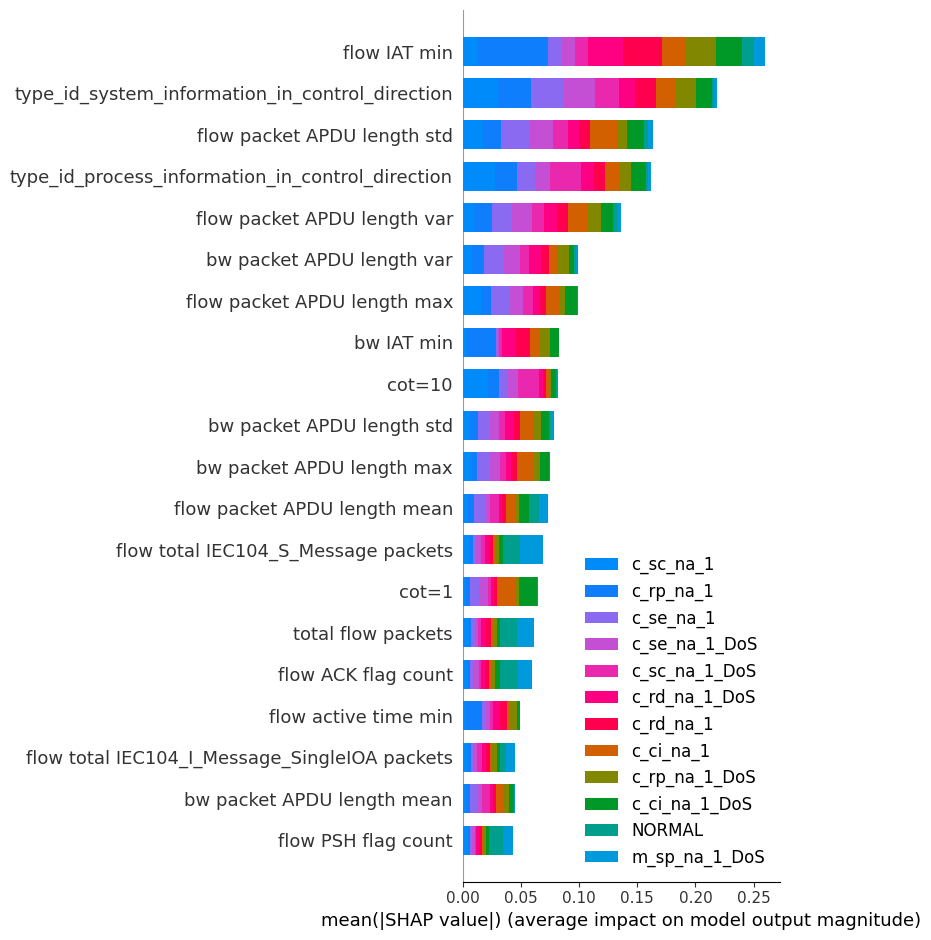

In [5]:
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=labels, show=False)

In [6]:
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=(0, 1))

feature_ranking = pd.DataFrame({'Feature': X_test.columns, 'Mean Absolute SHAP Value': mean_abs_shap_values})

feature_ranking = feature_ranking.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print(feature_ranking)

                                             Feature  Mean Absolute SHAP Value
13                                      flow IAT min                  0.021642
89   type_id_system_information_in_control_direction                  0.018241
34                       flow packet APDU length std                  0.013648
88  type_id_process_information_in_control_direction                  0.013465
35                       flow packet APDU length var                  0.011319
..                                               ...                       ...
71                                 fw avg bytes/bulk                  0.000124
73                                  fw avg bulk rate                  0.000123
37                         fw packet APDU length min                  0.000120
72                                 bw avg bytes/bulk                  0.000119
32                       flow packet APDU length min                  0.000000

[90 rows x 2 columns]


In [14]:
len(mean_abs_shap_values)

90

### Threshold 0.005

In [13]:
threshold = 0.0025
selected_features = feature_ranking[feature_ranking['Mean Absolute SHAP Value'] > threshold]['Feature'].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print(len(selected_features))

max = 0.0
index = 0

for j in range(1,15):
    i=j
    rf_params = {
        "n_estimators": i*100,
        "max_leaf_nodes": 15000,
        "n_jobs": -1,
        "random_state": 0,
        "bootstrap": True,
        "criterion": "entropy"
    }
    
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X=X_train_selected, y=y_train)
    rf_prediction = rf_model.predict(X_test_selected)
    
    rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)

    if rf_acc > max:
        max = rf_acc
        index = i

print(max)
print(index)
    

26


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

0.8481262327416174
5


In [12]:
rf_params = {
    "n_estimators": 28,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("RandomForestClassifier Starting")
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X=X_train_selected_1, y=y_train)
rf_preds = rf_model.predict(X_test_selected_1)
rf_acc = accuracy_score(rf_preds, y_test)
print("ExtraTreesClassifier Accuracy:", rf_acc)

RandomForestClassifier Starting


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ExtraTreesClassifier Accuracy: 0.8653846153846154


In [4]:
def calculate_macro_tpr_fpr(voting_cm):
    num_classes = voting_cm.shape[0]
    tpr_list = []
    fpr_list = []

    for i in range(num_classes):
        TP = voting_cm[i, i]
        FN = np.sum(voting_cm[i, :]) - TP
        FP = np.sum(voting_cm[:, i]) - TP
        TN = np.sum(voting_cm) - (TP + FN + FP)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    macro_tpr = np.mean(tpr_list)
    macro_fpr = np.mean(fpr_list)

    return macro_tpr, macro_fpr

## Load data

In [2]:
X_train = pd.read_csv('./DS/CFM_DS_X_train.csv')
y_train = pd.read_csv('./DS/CFM_DS_y_train.csv')
X_test = pd.read_csv('./DS/X_test_SFS.csv')
y_test = pd.read_csv('./DS/y_test_SFS.csv')

def calculate_macro_tpr_fpr(voting_cm):
    num_classes = voting_cm.shape[0]
    tpr_list = []
    fpr_list = []

    for i in range(num_classes):
        TP = voting_cm[i, i]
        FN = np.sum(voting_cm[i, :]) - TP
        FP = np.sum(voting_cm[:, i]) - TP
        TN = np.sum(voting_cm) - (TP + FN + FP)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    macro_tpr = np.mean(tpr_list)
    macro_fpr = np.mean(fpr_list)

    return macro_tpr, macro_fpr

## XGBoost

In [11]:
xgb_params = {
    'device': 'cuda',
    'max_depth': 128,
    # 'n_estimators': 3000,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'eval_metric': 'auc'
}


print("XGBClassifier Starting")
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train,y_train)
# joblib.dump(xgb_model, './models/CFM_XGB.pkl')
# xgb_model = joblib.load('./models/CFM_XGB.pkl')
xgb_start_time = time.time()
xgb_prediction = xgb_model.predict(X_test)
xgb_end_time = time.time()
xgb_time = xgb_end_time - xgb_start_time
print("XGBClassifier Finished")

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
xgb_precision = sklearn.metrics.precision_score(xgb_prediction, y_test, average='macro')
xgb_f1 = sklearn.metrics.f1_score(xgb_prediction, y_test, average='macro')
xgb_recall = sklearn.metrics.recall_score(xgb_prediction, y_test, average='macro')
xgb_cm = sklearn.metrics.confusion_matrix(xgb_prediction, y_test)
xgb_probs = xgb_model.predict_proba(X_test)
xgb_auc = sklearn.metrics.roc_auc_score(y_test, xgb_probs, average='macro', multi_class='ovr')
xgb_tpr, xgb_fpr = calculate_macro_tpr_fpr(xgb_cm)
print("XGBoost report:")
print("XGBoost Time:", xgb_time)
print("XGBoost Accuracy:", xgb_acc)
print("XGBoost Precision:", xgb_precision)
print("XGBoost F1:", xgb_f1)
print("XGBoost Recall:", xgb_recall)
print("XGBoost ROC AUC:", xgb_auc)
print("XGBoost CM:\n", xgb_cm)
print(f'XGBoost Macro-average TPR: {xgb_tpr}')
print(f'XGBoost Macro-average FPR: {xgb_fpr}')

XGBClassifier Starting
XGBClassifier Finished
XGBoost report:
XGBoost Time: 0.05286812782287598
XGBoost Accuracy: 0.8530571992110454
XGBoost Precision: 0.8530571992110453
XGBoost F1: 0.8491116790372009
XGBoost Recall: 0.8500890580232068
XGBoost ROC AUC: 0.9875625057691512
XGBoost CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  36   0  12   0   0]
 [  0   0   0 169   0   0   0   1   0   0   0   0]
 [  0   0   0   0 169   1   0   0   0   0   0   0]
 [  0   0   0   0   0 168   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   1   0   0   0   0]
 [  0   0   0   0   0   0   0  77  40   6   0   0]
 [  0   0   0   0   0   0   0  32 129   0   0   0]
 [  0   0   0   0   0   0   0   9   0  90  86   0]
 [  0   0   0   0   0   0   0  12   0  61  83   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
XGBoost Macro-average TPR: 0.8500890580232068
XGBoost Macro-average FPR: 0.013255117364896749


## ExtraTree

In [10]:
et_params = {
    "n_estimators": 20,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("ExtraTreesClassifier Starting")
et_model = ExtraTreesClassifier(**et_params)
et_model.fit(X=X_train, y=y_train)
# joblib.dump(et_model, './models/CFM_ET.pkl')
# et_model = joblib.load('./models/CFM_ET.pkl')
et_start_time = time.time()
et_prediction = et_model.predict(X_test)
et_end_time = time.time()
et_time = et_end_time - et_start_time
print("ExtraTreesClassifier Finished")

et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
et_precision = sklearn.metrics.precision_score(et_prediction, y_test, average='macro')
et_f1 = sklearn.metrics.f1_score(et_prediction, y_test, average='macro')
et_recall = sklearn.metrics.recall_score(et_prediction, y_test, average='macro')
et_cm = sklearn.metrics.confusion_matrix(et_prediction, y_test)
et_probs = et_model.predict_proba(X_test)
et_auc = sklearn.metrics.roc_auc_score(y_test, et_probs, average='macro', multi_class='ovr')
et_tpr, et_fpr = calculate_macro_tpr_fpr(et_cm)
print("ExtraTrees report:")
print("ExtraTrees Time:", et_end_time - et_start_time)
print("ExtraTrees Accuracy:", et_acc)
print("ExtraTrees Precision:", et_precision)
print("ExtraTrees F1:", et_f1)
print("ExtraTrees Recall:", et_recall)
print("ExtraTrees ROC AUC:", et_auc)
print("ExtraTrees CM:\n", et_cm)
print(f'ExtraTrees Macro-average TPR: {et_tpr}')
print(f'ExtraTrees Macro-average FPR: {et_fpr}')

ExtraTreesClassifier Starting
ExtraTreesClassifier Finished
ExtraTrees report:
ExtraTrees Time: 0.03616690635681152
ExtraTrees Accuracy: 0.8619329388560157
ExtraTrees Precision: 0.8619329388560159
ExtraTrees F1: 0.8577654430290286
ExtraTrees Recall: 0.8608286969794708
ExtraTrees ROC AUC: 0.9838247589157921
ExtraTrees CM:
 [[168   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  30   0  11   0   0]
 [  0   0   0 169   0   2   0   0   0   0   0   0]
 [  0   0   0   0 168   0   0   0   0   0   0   0]
 [  0   0   0   0   0 164   0   0   0   0   0   0]
 [  0   0   0   0   1   3 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  84  33   6   0   0]
 [  0   0   0   0   0   0   0  37 136   0   0   0]
 [  1   0   0   0   0   0   0   7   0 109  95   0]
 [  0   0   0   0   0   0   0  10   0  43  74   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
ExtraTrees Macro-average TPR: 0.8608286969794708
ExtraTrees Mac

## RandomForest

In [14]:
rf_params = {
    "n_estimators": 52,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("RandomForestClassifier Starting")
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X=X_train, y=y_train)
# joblib.dump(rf_model, './models/CFM_RF.pkl')
# rf_model = joblib.load('./models/CFM_RF.pkl')
rf_start_time = time.time()
rf_prediction = rf_model.predict(X_test)
rf_end_time = time.time()
rf_time = rf_end_time - rf_start_time
print("RandomForestClassifier Finished")

rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)
rf_precision = sklearn.metrics.precision_score(rf_prediction, y_test, average='macro')
rf_f1 = sklearn.metrics.f1_score(rf_prediction, y_test, average='macro')
rf_recall = sklearn.metrics.recall_score(rf_prediction, y_test, average='macro')
rf_cm = sklearn.metrics.confusion_matrix(rf_prediction, y_test)
rf_probs = rf_model.predict_proba(X_test)
rf_auc = sklearn.metrics.roc_auc_score(y_test, rf_probs, average='macro', multi_class='ovr')
rf_tpr, rf_fpr = calculate_macro_tpr_fpr(rf_cm)
print("RandomForest report:")
print("RandomForest Time:", rf_end_time - rf_start_time)
print("RandomForest Accuracy:", rf_acc)
print("RandomForest Precision:", rf_precision)
print("RandomForest F1:", rf_f1)
print("RandomForest Recall:", rf_recall)
print("RandomForest ROC AUC:", rf_auc)
print("RandomForest CM:\n", rf_cm)
print(f'RandomForest Macro-average TPR: {rf_tpr}')
print(f'RandomForest Macro-average FPR: {rf_fpr}')

RandomForestClassifier Starting
RandomForestClassifier Finished
RandomForest report:
RandomForest Time: 0.0543670654296875
RandomForest Accuracy: 0.8678500986193294
RandomForest Precision: 0.8678500986193294
RandomForest F1: 0.8631102343886119
RandomForest Recall: 0.8676679556318093
RandomForest ROC AUC: 0.987399112797383
RandomForest CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  32   0  13   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   0   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  82  32   5   0   0]
 [  0   0   0   0   0   0   0  33 137   0   0   0]
 [  0   0   0   0   0   0   0   9   0 116  96   0]
 [  0   0   0   0   0   0   0  12   0  35  73   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
RandomForest Macro-average TPR: 0.86766795563

## Voting

In [8]:
xgb_model = XGBClassifier()
xgb_model = joblib.load('./models/CFM_XGB.pkl')
et_model = ExtraTreesClassifier()
et_model = joblib.load('./models/CFM_ET.pkl')
rf_model = RandomForestClassifier()
rf_model = joblib.load('./models/CFM_RF.pkl')

xgb_preds = xgb_model.predict_proba(X_test)
et_preds = et_model.predict_proba(X_test)
rf_preds = rf_model.predict_proba(X_test)

xgb_prediction = xgb_model.predict(X_test)
et_prediction = et_model.predict(X_test)
rf_prediction = rf_model.predict(X_test)

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)

print("XGBoost Accuracy:", xgb_acc)
print("ExtraTree Accuracy:", et_acc)
print("RandomForest Accuracy:", rf_acc)

[20:50:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



XGBoost Accuracy: 0.8530571992110454
ExtraTree Accuracy: 0.8619329388560157
RandomForest Accuracy: 0.8678500986193294


In [9]:
avgs = (
    0.001 * xgb_preds
    + 0.035 * et_preds
    + 0.964 * rf_preds
)

voting_prediction = avgs.argmax(axis=1)
voting_acc = sklearn.metrics.accuracy_score(voting_prediction, y_test)
voting_precision = sklearn.metrics.precision_score(voting_prediction, y_test, average='macro')
voting_f1 = sklearn.metrics.f1_score(voting_prediction, y_test, average='macro')
voting_recall = sklearn.metrics.recall_score(voting_prediction, y_test, average='macro')
voting_cm = sklearn.metrics.confusion_matrix(voting_prediction, y_test)
voting_auc = sklearn.metrics.roc_auc_score(y_test, avgs, average='macro', multi_class='ovr')
macro_tpr, macro_fpr = calculate_macro_tpr_fpr(voting_cm)
print("Voting report:")
print("Voting Accuracy:", voting_acc)
print("Voting Precision:", voting_precision)
print("Voting F1:", voting_f1)
print("Voting Recall:", voting_recall)
print("Voting ROC AUC:", voting_auc)
print("Voting CM:\n", voting_cm)
print(f'Voting Macro-average TPR: {macro_tpr}')
print(f'Voting Macro-average FPR: {macro_fpr}')

Voting report:
Voting Accuracy: 0.8683431952662722
Voting Precision: 0.8683431952662722
Voting F1: 0.8638730105013145
Voting Recall: 0.8679647207915605
Voting ROC AUC: 0.9892171248566332
Voting CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  30   0  13   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   0   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  83  32   5   0   0]
 [  0   0   0   0   0   0   0  33 137   0   0   0]
 [  0   0   0   0   0   0   0   9   0 115  95   0]
 [  0   0   0   0   0   0   0  13   0  36  74   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
Voting Macro-average TPR: 0.8679647207915605
Voting Macro-average FPR: 0.011834642347643707


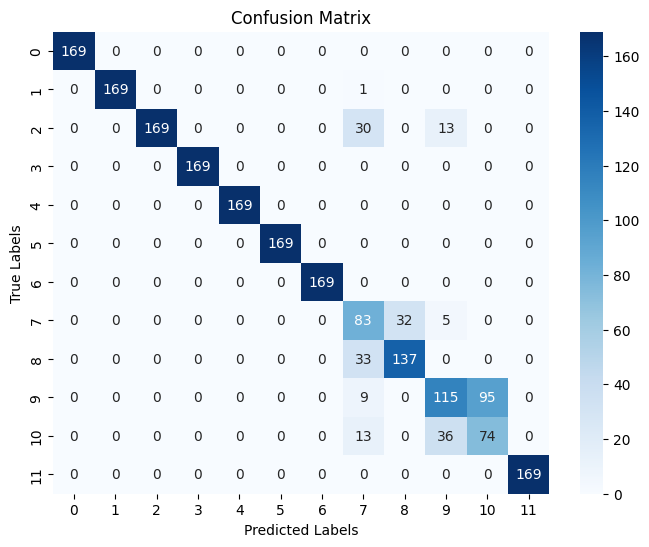

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(voting_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()